# 1. Installing the Transformers

In [ ]:
!pip install transformers
!pip install nltk

     |████████████████████████████████| 2.3MB 4.3MB/s 
     |████████████████████████████████| 901kB 20.7MB/s 
     |████████████████████████████████| 3.3MB 27.8MB/s 


# 2. Importing and Cleaning the data


In [ ]:
#Importing all the necessary libraries 
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns
import re
import json
import torch
import gc
from torch.utils.data import Dataset, random_split, Subset
from transformers import GPT2Tokenizer, TrainingArguments, Trainer, GPT2LMHeadModel
import nltk
from nltk import word_tokenize

In [ ]:
#Reading the json file
df = pd.read_json('/content/Dataset for Detection of Cyber-Trolls.json', orient='records', lines=True)
df

,content,annotation,extras
0,Get fucking real dude.,"{'notes': '', 'label': ['1']}",NaN
1,She is as dirty as they come and that crook ...,"{'notes': '', 'label': ['1']}",NaN
2,why did you fuck it up. I could do it all day...,"{'notes': '', 'label': ['1']}",NaN
3,Dude they dont finish enclosing the fucking s...,"{'notes': '', 'label': ['1']}",NaN
4,WTF are you talking about Men? No men thats n...,"{'notes': '', 'label': ['1']}",NaN
...,...,...,...
19996,I dont. But what is complaining about it goi...,"{'notes': '', 'label': ['0']}",NaN
19997,Bahah yeah i&;m totally just gonna&; get pis...,"{'notes': '', 'label': ['0']}",NaN
19998,hahahahaha >:) im evil mwahahahahahahahahaha,"{'notes': '', 'label': ['0']}",NaN
19999,What&;s something unique about Ohio? :),"{'notes': '', 'label': ['0']}",NaN


In [ ]:
#Strip whitespaces at the beginning and end of the tweets
df['content'] = df['content'].str.strip()
df['content'].head()

0                               Get fucking real dude.
1    She is as dirty as they come  and that crook R...
2    why did you fuck it up. I could do it all day ...
3    Dude they dont finish enclosing the fucking sh...
4    WTF are you talking about Men? No men thats no...
Name: content, dtype: object

In [ ]:
#Remove missing values such as "
df = df.drop(df[df['content'] == '"'].index) # 5 rows removed

#Remove duplicates
df = df.drop(df[df.duplicated(subset=['content'])].index) # 5368 duplicate rows removed
df.shape

(14627, 3)

In [ ]:
#Remove hyperlinks within tweets
df[df['content'].str.match(r'http\S+')==True].count() # 54 rows removed with links
df[df['content'].str.match(r'www\S+')==True].count() # 2 rows removed with links
df['content'] = df['content'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)


In [ ]:
#Simplifying and renaming 'annotation' column to 'label'. label=1 indicates aggressive tweet
df[['notes', 'label']] = df['annotation'].apply(pd.Series)
df['label'] = df['label'].apply(lambda x: int(x[0]))
df.drop('annotation', axis=1, inplace = True)
df = df[['content', 'label']]
df.head()

,content,label
0,Get fucking real dude.,1
1,She is as dirty as they come and that crook R...,1
2,why did you fuck it up. I could do it all day ...,1
3,Dude they dont finish enclosing the fucking sh...,1
4,WTF are you talking about Men? No men thats no...,1


# 3. Loading the Pre-trained *GPT*-2 Transformer



In [ ]:
#get transformers
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

#get GPT2 tokenizer and GPT2 model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium",
                            bos_token="<|startoftext|>",
                            eos_token="<|endoftext|>",
                            pad_token="<|pad|>")

# Download the pre-trained GPT-Neo model and transfer it to the GPU
model = GPT2LMHeadModel.from_pretrained("gpt2-medium")
gc.collect()
model = model.cuda()

# Resize the token embeddings because we've just added 3 new tokens
model.resize_token_embeddings(len(tokenizer))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Embedding(50259, 1024)

# 3. Exploratory Data Analysis (EDA)

In [ ]:
#Find word/token length of each tweet
length_words = []
for content in df['content'].values:
    length_words.append(len(tokenizer.encode(content, return_tensors='np')[0]))
df['len_words'] = length_words
df.head()

,content,label,len_words
0,Get fucking real dude.,1,5
1,She is as dirty as they come and that crook R...,1,33
2,why did you fuck it up. I could do it all day ...,1,35
3,Dude they dont finish enclosing the fucking sh...,1,29
4,WTF are you talking about Men? No men thats no...,1,21


In [ ]:
#Find number of sentences per tweet
df['len_sentences'] = df['content'].apply(lambda x: len(re.split('(?<=[.!?]) +', x)))
df.head()

,content,label,len_words,len_sentences
0,Get fucking real dude.,1,5,1
1,She is as dirty as they come and that crook R...,1,33,2
2,why did you fuck it up. I could do it all day ...,1,35,4
3,Dude they dont finish enclosing the fucking sh...,1,29,4
4,WTF are you talking about Men? No men thats no...,1,21,2


In [ ]:
#Find number of characters per tweet
df['len_chars'] = df['content'].apply(len)
df.head()

,content,label,len_words,len_sentences,len_chars
0,Get fucking real dude.,1,5,1,22
1,She is as dirty as they come and that crook R...,1,33,2,129
2,why did you fuck it up. I could do it all day ...,1,35,4,129
3,Dude they dont finish enclosing the fucking sh...,1,29,4,125
4,WTF are you talking about Men? No men thats no...,1,21,2,74


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14627 entries, 0 to 20000
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        14627 non-null  object
 1   label          14627 non-null  int64 
 2   len_words      14627 non-null  int64 
 3   len_sentences  14627 non-null  int64 
 4   len_chars      14627 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 685.6+ KB


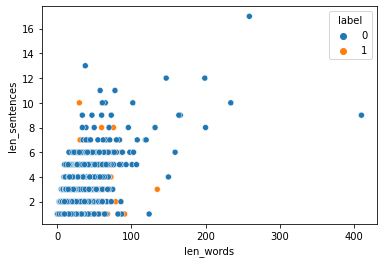

In [ ]:
#Plot number of words against number of sentences. Orange data points are aggressive tweets
sns.scatterplot(data = df, x = 'len_words', y = 'len_sentences', hue='label')
plt.show()

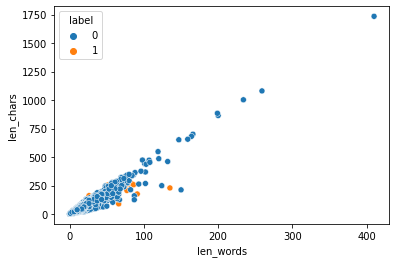

In [ ]:
#Plot number of words against number of characters. Orange data points are aggressive tweets
sns.scatterplot(data = df, x = 'len_words', y = 'len_chars', hue='label')
plt.show()

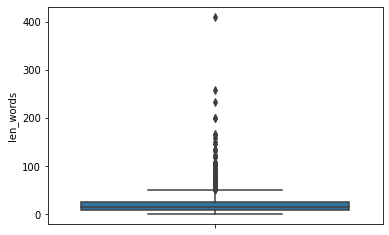

In [ ]:
#Determine outliers for number of words
sns.boxplot(data = df, y = 'len_words')
plt.show()

In [ ]:
df['len_words'].describe()

count    14627.000000
mean        18.003487
std         12.762766
min          0.000000
25%          9.000000
50%         16.000000
75%         26.000000
max        410.000000
Name: len_words, dtype: float64

In [ ]:
#Examine 3D plot using 3 variables 
import plotly.express as px
# df = px.data.iris()
fig = px.scatter_3d(df, x='len_chars', y='len_words', z='len_sentences',
              color='label')
fig.show()

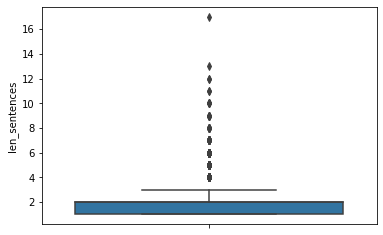

In [ ]:
#Determine outliers for number of sentences
sns.boxplot(data = df, y = 'len_sentences')
plt.show()

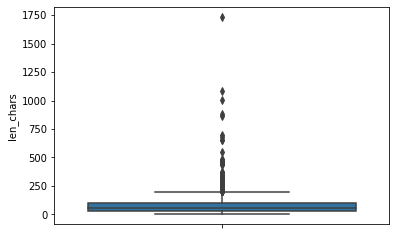

In [ ]:
#Determine outliers for number of chars
sns.boxplot(data = df, y = 'len_chars')
plt.show()

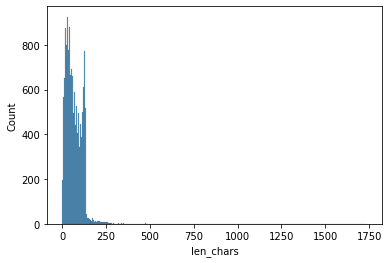

In [ ]:
sns.histplot(data = df, x = 'len_chars')
plt.show()

In [ ]:
# Average char length of tweets 67. Tweets with char length greater than 99 will be considered outliers and removed.
df['len_chars'].describe()

count    14627.000000
mean        66.981404
std         49.690762
min          0.000000
25%         31.000000
50%         58.000000
75%         99.000000
max       1736.000000
Name: len_chars, dtype: float64

# 4. Remove Outliers & Filter Single-word Comments

In [ ]:
#Remove outliers outside of IQR (>99 chars)
df = df[ df['len_chars'] <= 99 ]
df.describe()   # 10984 rows after cleaning

,label,len_words,len_sentences,len_chars
count,10984.000000,10984.000000,10984.000000,10984.000000
mean,0.179443,12.913055,1.576020,46.646031
std,0.383740,6.988785,0.821418,25.781688
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,7.000000,1.000000,25.000000
50%,0.000000,12.000000,1.000000,43.000000
75%,0.000000,18.000000,2.000000,67.000000
max,1.000000,66.000000,8.000000,99.000000


In [ ]:
#For purposes of Artifical Non-Intelligence guessing game, remove single word tweets because not enough context for player to guess
df = df.drop(df[df['len_words'] <= 1].index)  
df.shape

(10919, 5)

# 5. Create Batches 

First separating dataset of Aggressive (Troll) tweets in case only wish to use troll tweets in game.

In [ ]:
#Create new df of just troll tweets. Fake=0 indicates tweet is human-generated ('real')
df_troll = df[ df['label'] == 1 ] 
df_troll['fake'] = 0  
df_troll = df_troll[['content','label', 'fake']].reset_index(drop=True)
df_troll.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,content,label,fake
0,Get fucking real dude.,1,0
1,WTF are you talking about Men? No men thats no...,1,0
2,LOL no he said What do you call a jail cell ...,1,0
3,Shakespeare nerd!,1,0
4,you are SUCH a fucking dork,1,0


In [ ]:
#Output troll tweets to json and csv files
df_troll.to_json('real_tweets_aggressive.json')
df_troll.to_csv('real_tweets_aggressive.csv')

In [ ]:
#Create new df of just non-aggressive tweets(Label=0). Fake=0 indicates tweet is human-generated ('real')
df_nonagg = df[ df['label'] == 0]
df_nonagg['fake'] = 0 
df_nonagg = df_nonagg[['content','label', 'fake']].reset_index(drop=True)
df_nonagg.head()
df_nonagg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8949 entries, 0 to 8948
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  8949 non-null   object
 1   label    8949 non-null   int64 
 2   fake     8949 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 209.9+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Output non-aggressive tweets to json and csv files
df_nonagg.to_json('real_tweets_nonaggressive.json')
df_nonagg.to_csv('real_tweets_nonaggressive.csv')

To generate only aggressive (troll) tweets, run cell below to encode only tweets with label=1

In [ ]:
descriptions = df_trolls['content']
max_length = max([len(tokenizer.encode(description)) for description in descriptions])
print(max_length)

To generate non-aggressive tweets, run cell below to encode tweets with label=0

In [ ]:
descriptions = df_nonagg['content']
max_length = max([len(tokenizer.encode(description)) for description in descriptions])
print(max_length)

50


 Below is the "Dataset" object. This is actually a pyTorch object that makes it easy to creates batches of data. As you can see, it happens the beginning and end of sentence tokens, and does padding on top. 

In [ ]:
class BatchDataset(Dataset):
    def __init__(self, txt_list, tokenizer, max_length):
        self.input_ids = []
        self.attn_masks = []
        self.labels = []
        for txt in txt_list:
            encodings_dict = tokenizer('<|startoftext|>' + txt + '<|endoftext|>', truncation=True,
                                       max_length=max_length, padding="max_length")
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

**Preprocess** data data, & split into train/val!

In [ ]:
dataset = BatchDataset(descriptions, tokenizer, max_length=max_length)

In [ ]:
# Two objects: the tokens, and the mask. Use tokenizer.eos_token_id (& bos_token_id & pad_token_id) 
# to understand how each token is represented numerically
print(dataset[0])
print(tokenizer.eos_token_id)
print(tokenizer.bos_token_id)
print(tokenizer.pad_token_id)

(tensor([50257, 42773, 19462,  5238,   588,   257,  1256,   286, 18314,   788,
          339,   258,   258, 50256, 50258, 50258, 50258, 50258, 50258, 50258,
        50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
        50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
        50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]))
50256
50257
50258


In [ ]:
# Proportion of train observations
# set random seed

torch.manual_seed(42)
random.seed(42)

train_prop = .9

In [ ]:
train_size = round(len(dataset) * train_prop)
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

In [ ]:
print(len(train_dataset)) ; print(len(val_dataset))

8054
895


Use the following to undersize the train dataset (for fast iterations on smaller train set). You will then use lenn than train_prop.

Put **None** if you want to use all of it. Note that this won't afect the size of the validation set.

In [ ]:
train_subsample_size = None # int or None (None for as much train data as possible)

In [ ]:
if train_subsample_size is not None:
  assert train_subsample_size <= len(dataset)
  train_dataset_sub = Subset(train_dataset, list(range(train_subsample_size)))
else:
  train_dataset_sub = train_dataset

In [ ]:
print(len(train_dataset_sub)) ; print(len(val_dataset))

8054
895


#6. Fine-tuning (not necessary if providing primer text)

**Training** arguments. Please note that none of them are specific to HuggingFace, so you'll be able to use your experience on those for any Deep Learning project.

You will want to dive in [the documentation](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments) for this class. With that said, here are the **most important arguments**. 

Those you already know:
* **num_train_epochs** (3-4 can prove enough with a small dataset)
* **per_device_train_batch_size & per_device_eval_batch_size** (use the same value for both)
* **learning_rate** (by default, the used optimizer is *AdamW*, which is just Adam with a trick for better regularization)

Those you are less familiar with, but still important:
* **weight_decay** : the regularization parameter for Adam (L2 regularization, which you have studied during class).
* **logging_steps and eval_steps**: Trainer will show you the training progress every logging_step & eval_steps batch. For starter, set it to 100, so that you get a solid idea of the evolution of the train & val losses. When you get used to all this, you may want to increase the step to save time during training.
* **save_strategy and save_steps**: how often should the model parameter be saved? By default, I advise you to set save_strategy="no", or this will kill your Colab storage space. 
* **load_best_model_at_end** : if model is saved at each save_steps, then get the best one. My advice: set it to False.


Some you may not know but want to play with
* **lr_scheduler_type** : by default, ["linear"](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup) (you should leave it as such). In that case, you learning rate will start from a very low value, and then reach the learning_rate you've set. Then will go down slowly. This prevents the parameters from moving like crazy at the beginning of the learning, and from moving too much at the end of the learning, when we are already supposed to be in a good spot in term of network weights.
* **warmup_steps**: how many batches should be seen by the Trainer before the learning rate reaches lr_scheduler_type? Too high values for warmup_steps will prevent your trainer from explore enough values for the weights. Too low, and might get crazy. Good values can be between 50 and 250.
* **adam_beta1, adam_beta2** : I don't consider them to be the most important in Deep Learning, but I'm sure some do and get good results through them :-)

In [ ]:
training_args = TrainingArguments(      
    seed=42,
    output_dir='./results', 
    num_train_epochs=4,
    learning_rate=5e-5, 
    weight_decay=1e-5,
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=16, 
    evaluation_strategy="steps",
    logging_steps=100, 
    eval_steps=100,
    save_strategy="no",
    load_best_model_at_end=False,
    lr_scheduler_type="linear",
    warmup_steps=100, 
)

In [ ]:
Trainer(model=model, args=training_args, train_dataset=train_dataset_sub,
        eval_dataset=val_dataset, data_collator=lambda data: {'input_ids': torch.stack([f[0] for f in data]),
                                                              'attention_mask': torch.stack([f[1] for f in data]),
                                                              'labels': torch.stack([f[0] for f in data])}).train()

Step,Training Loss,Validation Loss
100,5.389400,1.244549
200,1.209500,1.189346
300,1.172500,1.173326
400,1.152500,1.164132
500,1.163100,1.161268
600,1.019000,1.168671
700,1.007900,1.164525
800,1.017000,1.162356
900,0.995400,1.161559
1000,1.023300,1.162174


TrainOutput(global_step=2016, training_loss=1.1841014193163977, metrics={'train_runtime': 1278.4129, 'train_samples_per_second': 1.577, 'total_flos': 3429314747596800.0, 'epoch': 4.0, 'init_mem_cpu_alloc_delta': 4096, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 13373440, 'train_mem_gpu_alloc_delta': 4271673344, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 3541659136})

#7. Creating Primer Text (not needed if fine-tuning)

 Primer text is given to the text generation model as a prompt. Generally, if fine-tuning has already been done, then only a begining-of-sentence token like <|startoftext|> is provided to prompt the model. Conversely, if primer text is provided as a prompt, then fine-tuning beforehand is usually not done.

Run cell below to create primer text using aggressive (troll) tweets.

In [ ]:
#Randomly select tweets then add 'Tweet: ' before each comment to give additional context

pd.set_option('display.max_colwidth', -1) # allow display to see full tweet length

#Use df_troll for sampling aggressive tweets
tweet_sample = df_troll['content'].sample(n=10)     #set number (n) of tweets to serve as primer text
tweet_sample = 'Tweet: ' + tweet_sample
tweet_sample = tweet_sample.reset_index(drop=True)
tweet_sample.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



0    Tweet: I will super hero my ass out there and blow the tire up myself!!!                       
1    Tweet: Yea it sucks!!                                                                          
2    Tweet: thx for the well wishes lisa! i hate taking meds  so i'm all for fast healing:)         
3    Tweet: hehe "fucking shift" ... never heard of it in six months..... u get to fuck in da shift?
4    Tweet: Me  too. Now I'm dragging my mature ass off to BED! G'night hawt girlie! Woot!          
5    Tweet: omg! what are you in the mood for.. i crock pot my ass off!                             
6    Tweet: yeah but zro rly is the eMo city don                                                    
7    Tweet: haha ugh this sucks :(                                                                  
8    Tweet: omg I know  everyone tells me I'm a twitter whore  lol                                  
9    Tweet: you fart like a fucking bass drum lol                                          

Run cell below to create primer text using non-aggressive tweets.

In [ ]:
#Randomly select tweets then add 'Tweet: ' before each comment to give additional context

pd.set_option('display.max_colwidth', -1) # allow display to see full tweet length

#Use df_nonagg for sampling non-aggressive tweets
tweet_sample = df_nonagg['content'].sample(n=20)     #set number (n) of tweets to serve as primer text
tweet_sample = 'Tweet: ' + tweet_sample
tweet_sample = tweet_sample.reset_index(drop=True)
tweet_sample.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



0    Tweet: You'd god damn well better be an Engineer. all I'm saying.                        
1    Tweet: Damn! He is like the male Rosie O'Donnell.                                        
2    Tweet: so cute  that you're undoubtedly the gay lord of homopedia.                       
3    Tweet: that totally sucks! I know who's gonna get grinched now! damn danville-ites &gt;:(
4    Tweet: How would a world without music affect us?                                        
Name: content, dtype: object

In [ ]:
#Concatenating tweet sample into single string for primer text.
text = tweet_sample.str.cat(others=None, sep='\n')
primer_text = text + '\nTweet:'
primer_text

'Tweet: I will super hero my ass out there and blow the tire up myself!!!\nTweet: Yea it sucks!!\nTweet: thx for the well wishes lisa! i hate taking meds  so i\'m all for fast healing:)\nTweet: hehe "fucking shift" ... never heard of it in six months..... u get to fuck in da shift?\nTweet: Me  too. Now I\'m dragging my mature ass off to BED! G\'night hawt girlie! Woot!\nTweet: omg! what are you in the mood for.. i crock pot my ass off!\nTweet: yeah but zro rly is the eMo city don\nTweet: haha ugh this sucks :(\nTweet: omg I know  everyone tells me I\'m a twitter whore  lol\nTweet: you fart like a fucking bass drum lol\nTweet:'

#8. Tweet Generation

In [ ]:
encoded_input = tokenizer(primer_text, return_tensors="pt").input_ids.cuda()    #To use primer text, replace first argument with:  primer_text
len_encoded_input = encoded_input.shape[1]

for i in range(5):
      generated_text_samples = model.generate(        
      encoded_input, 
      bos_token_id=tokenizer.bos_token_id,  # No use
      eos_token_id=tokenizer.eos_token_id, # No use
      pad_token_id=tokenizer.pad_token_id,
      do_sample=True,  
      max_length = len_encoded_input + 26,    # length of encoded input plus the number of tokens/words (careful not char length!) for output
      top_p=0.95,          # experimented with range: 0.5 (too nice, short, and tame) to 0.99 (too random, longer, and more incoherent )  w/holding top_k at 25
      temperature=1.75,   # experimented with range: 0.7 (too ordinary and tame) to 2.0 (too random and includes more gibberish)  
      num_return_sequences=5,    #Set equal to number of for loop iterations (each loop outputs one generated tweet)
      top_k=25,     #experimented with range: 5 (tame and less negative) to 50 (too random and includes more gibberish)  w/ holding top_p at 0.9
      output_scores=False, 
      return_dict_in_generate=False
     )

#Print 1st example of generated tweet
print("Output:\n")
print(tokenizer.decode(generated_text_samples[0], skip_special_tokens=True))

Output:

Tweet: I will super hero my ass out there and blow the tire up myself!!!
Tweet: Yea it sucks!!
Tweet: thx for the well wishes lisa! i hate taking meds  so i'm all for fast healing:)
Tweet: hehe "fucking shift"... never heard of it in six months..... u get to fuck in da shift?
Tweet: Me  too. Now I'm dragging my mature ass off to BED! G'night hawt girlie! Woot!
Tweet: omg! what are you in the mood for.. i crock pot my ass off!
Tweet: yeah but zro rly is the eMo city don
Tweet: haha ugh this sucks :(
Tweet: omg I know  everyone tells me I'm a twitter whore  lol
Tweet: you fart like a fucking bass drum lol
Tweet: YAY mey ya no


For fine-tuned model that did not include primer text, run cell below to collect all generated tweets into list

In [ ]:
fake_tweets = []
for i in range(5):
  output = tokenizer.decode(generated_text_samples[i], skip_special_tokens=True)
  fake_tweets.append(output)
fake_tweets[:5]

For models without and only primer text, run cell below to collect all generated tweets into list

In [ ]:
#Remove 'primer text' and collect all generated tweets into single list
fake_tweets = []
for i in range(5):
  output = tokenizer.decode(generated_text_samples[i], skip_special_tokens=True)
  generated_tweet = output.split('Tweet: ')[-1:]
  fake_tweets.append(generated_tweet)
fake_tweets[:5]

[['YAY mey ya no'],
 ['  ugh'],
 ['@johnstron on em. It just says "you" ha hahaha'],
 ['you fart like a fucking bass drum lol\nTweet:'],
 ['*hug*']]

In [ ]:
fake_tweets_df = pd.DataFrame(fake_tweets)
fake_tweets_df.columns= ['content']
fake_tweets_df['label'] = 1   # change to 1 for aggressive,  0 for non-agressive 
fake_tweets_df['fake'] = 1
fake_tweets_df.head()

,content,label,fake
0,YAY mey ya no,1,1
1,ugh,1,1
2,"@johnstron on em. It just says ""you"" ha hahaha",1,1
3,you fart like a fucking bass drum lol\nTweet:,1,1
4,*hug*,1,1


In [ ]:
fake_tweets_df.to_json('500_hundred_fake_tweets_nonaggressive_4.json')
fake_tweets_df.to_csv('500_hundred_fake_tweets_nonaggressive_4.csv')